# Feature Exploration

In [1]:
# Import libraries
import imageio
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage.io import imshow
import skimage
import skimage.transform
import numpy as np
import pandas as pd
import seaborn as sns
import py7zr

sns.set_theme(context='notebook', style='dark', palette = 'autumn')

In [10]:
# Import raw datasets 
def img_imp(name):
    path = "datasets/"+name+'.npy'
    return np.load(path)

# Normalize matrix
def norm(mat):
    mat_max = mat.max()
    mat_min = mat.min()
    new_mat = (mat - mat_min) / (mat_max - mat_min)
    return new_mat

# Function to flatten a 3D Matrix two 2D 
def flatten_3D_matrix(mat):
    mat_len = mat.shape[0]*mat.shape[1]
    mat_flat = mat.reshape(mat_len , mat.shape[2])
    return mat_flat

# Flatten a 2D to 1D
def flatten_2D_matrix(mat):
    mat_len = mat.shape[0]*mat.shape[1]
    mat_flat = mat.reshape(mat_len)
    return mat_flat

# Prep label matrix
# Change to binary, remove noise (30000 selected arbitrarily based on histogram)
def prep_labels(mat):
    mat_new = mat.copy()
    mat_new[mat < 30000] = 0
    mat_new[mat >= 30000] = 1
    return mat_new

# Feature prep: Calcs NDVI + Moisture index, Stacks features, and Resizes to match Label set
def prep_features():
    # Calculate NDVI + Moisture Index,  Stack rgb
    ndvi = np.true_divide((ir - r), (ir + r))
    mstr = np.true_divide((ir - SWIR1), (ir + SWIR1))
    rgb = np.dstack((r, g, b))
    
    # Resize features
    rgb_big = skimage.transform.resize(rgb, output_shape=(pan.shape[0],pan.shape[1],3), order=3, mode='constant', cval=0.0)
    ir_big = skimage.transform.resize(ir, output_shape=(pan.shape[0],pan.shape[1]), order=3, mode='constant', cval=0.0) 
    coast_big = skimage.transform.resize(coast, output_shape=(pan.shape[0],pan.shape[1]), order=3, mode='constant', cval=0.0)  
    ndvi_big = skimage.transform.resize(ndvi, output_shape=(pan.shape[0],pan.shape[1]), order=3, mode='constant', cval=0.0) 
    mstr_big = skimage.transform.resize(mstr, output_shape=(pan.shape[0],pan.shape[1]), order=3, mode='constant', cval=0.0) 
    
    # Sharpen RGB
    hsv = skimage.color.rgb2hsv(rgb_big)   
    hsv[...,2]=pan                     
    rgb_sharp = skimage.color.hsv2rgb(hsv)   
    
    # Stack all [r, g, b, ir, coast, ndvi, moisture]
    features = np.dstack((rgb_sharp, ir_big, coast_big, ndvi_big, mstr_big))
    return features

In [27]:
# Unzip pan band
with py7zr.SevenZipFile('datasets/pan.7z', mode='r') as pan: 
    pan.extractall("datasets/pan") 

In [29]:
# Import raw datasets
r = norm( img_imp('red') )
g = norm( img_imp('green') )
b = norm( img_imp('blue') )
ir = norm( img_imp('ir') )
coast = norm( img_imp('coast') )
SWIR1 = norm( img_imp('SWIR1') )
SWIR2 = norm( img_imp('SWIR2') ) # Currently note being used for anything
pan = img_imp('pan/pan')
labels = prep_labels ( img_imp('label') )

In [30]:
# Prep features (r, g, b, ir, ndvi)
features = prep_features()

In [31]:
# Prep some example RGB images
ex_big_rgb = features[1500:2000,1500:2000, 0:3] * 2.5 # *2.5 to brighten
ex_small_rgb = features[1400:1500,1400:1500, 0:3] * 2.5 
ex_big_label = labels[1500:2000,1500:2000]
ex_small_label = labels[1400:1500,1400:1500]

# Exploring Different Bands

In [6]:
band_names = ['Red', 'Green', 'Blue', 'IR', 'Coastal', 'NDVI', 'Moisture']

def feature_plot(band, notes):
    band_name = band_names[band]
    
    feat_small = features[1400:1500,1400:1500, band]
    feat_big = features[1500:2000,1500:2000, band]
    
    fig, ax = plt.subplots(2, 3, figsize=(11, 8), constrained_layout = True)
    
    ax[0,0].imshow( ex_small_rgb )
    ax[1,0].imshow( ex_big_rgb )
    ax[0,1].imshow( ex_small_label )
    ax[1,1].imshow( ex_big_label )
    ax[0,2].imshow( feat_small )
    ax[1,2].imshow( feat_big )
    
    ax[0,0].set_title('RGB', size = 20)
    ax[0,1].set_title('Labels', size = 20)
    ax[0,2].set_title('Band Result', size = 20)

    for axs in ax.flatten():
        axs.axis('off')

    title = str(band_name + notes)
    fig.suptitle(title, size = 20) 
    plt.savefig('images/feature_exploration_images/{}.png'.format(band_name))

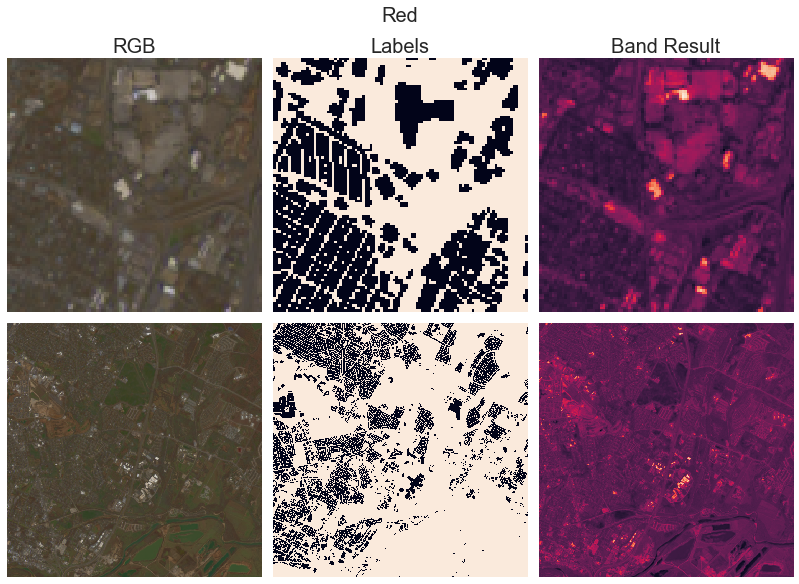

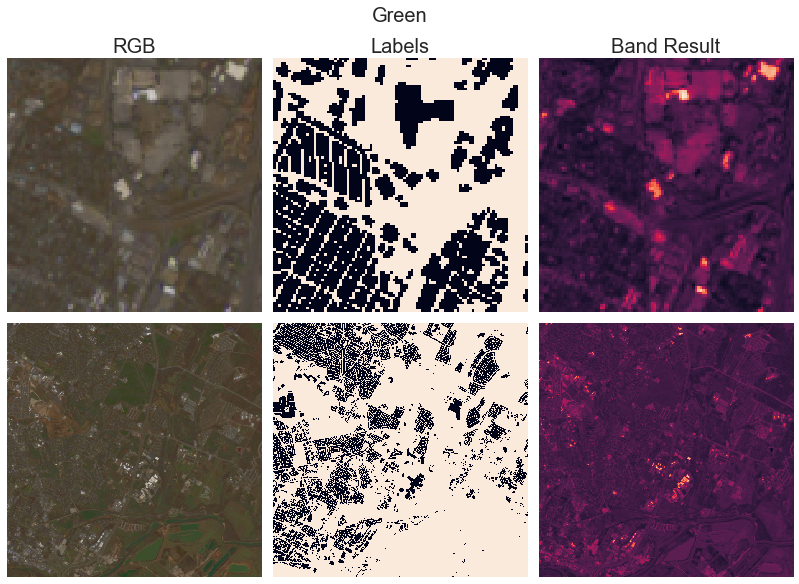

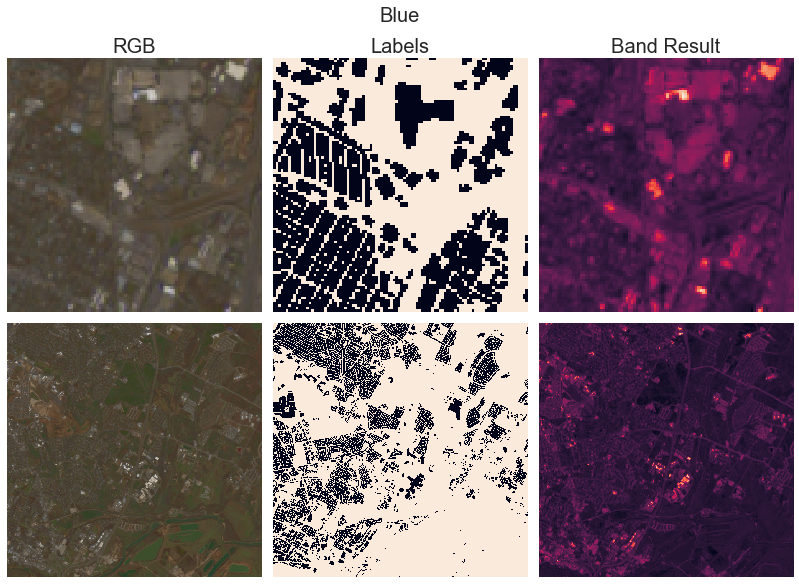

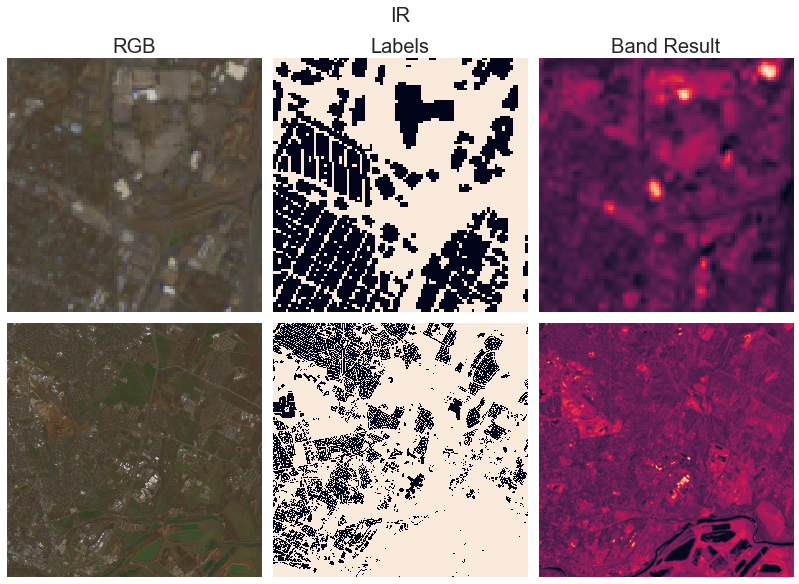

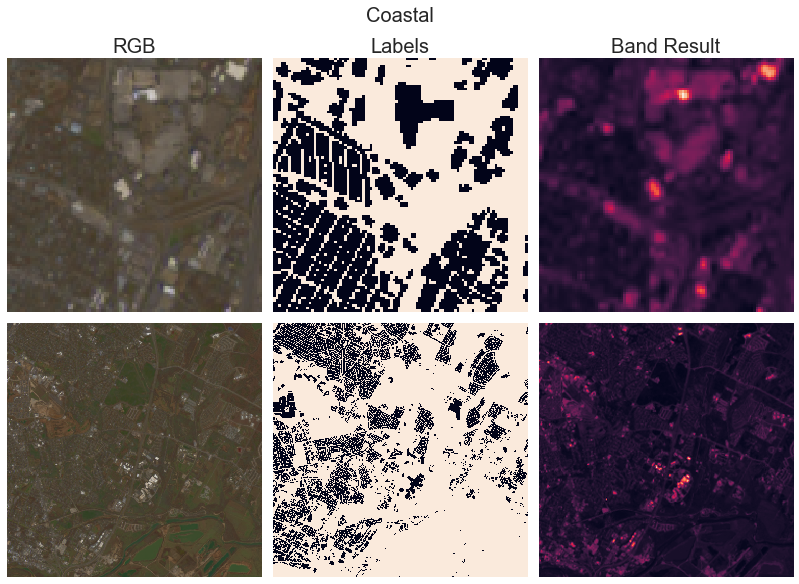

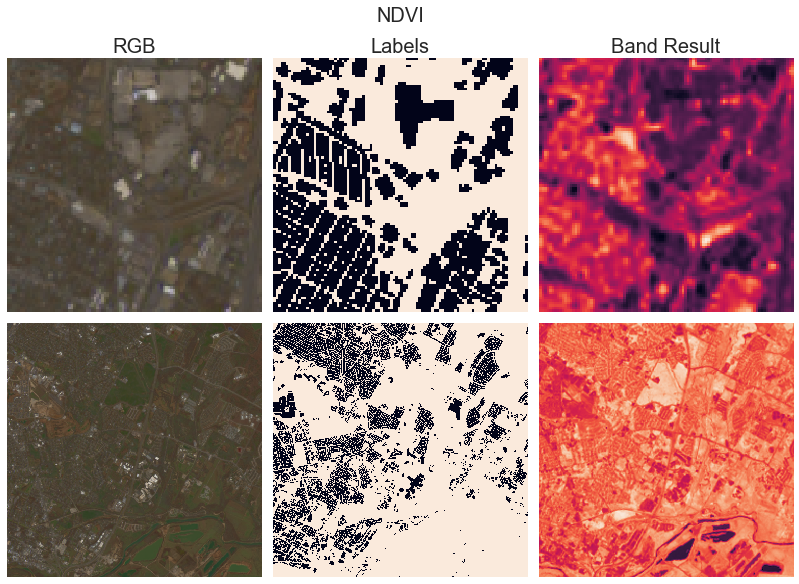

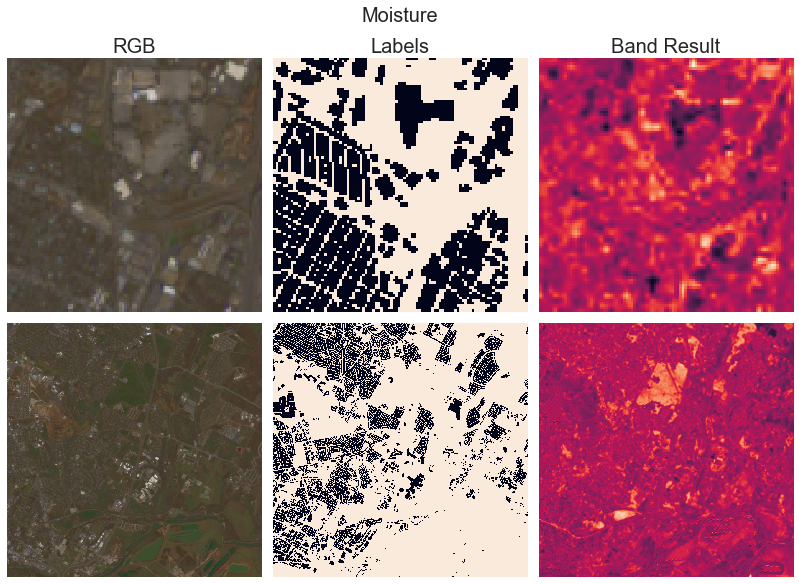

In [105]:
feature_plot(0, '') # Red
feature_plot(1, '') # Green
feature_plot(2, '') # Blue
feature_plot(3, '') # IR
feature_plot(4, '') # Coastal
feature_plot(5, '') # NDVI
feature_plot(6, '') # Moisture

# Relationships Between Bands

In [7]:
from sklearn.model_selection import train_test_split

# Make a flattened version of features dataframe
flat = pd.DataFrame(flatten_3D_matrix( features ))

# 10000 Samples
flat_sample, dummy = train_test_split( flat , train_size = 10000, random_state = 42)
flat_sample.columns = ['Red', 'Green', 'Blue', 'IR', 'Coastal', 'NDVI', 'Moisture']

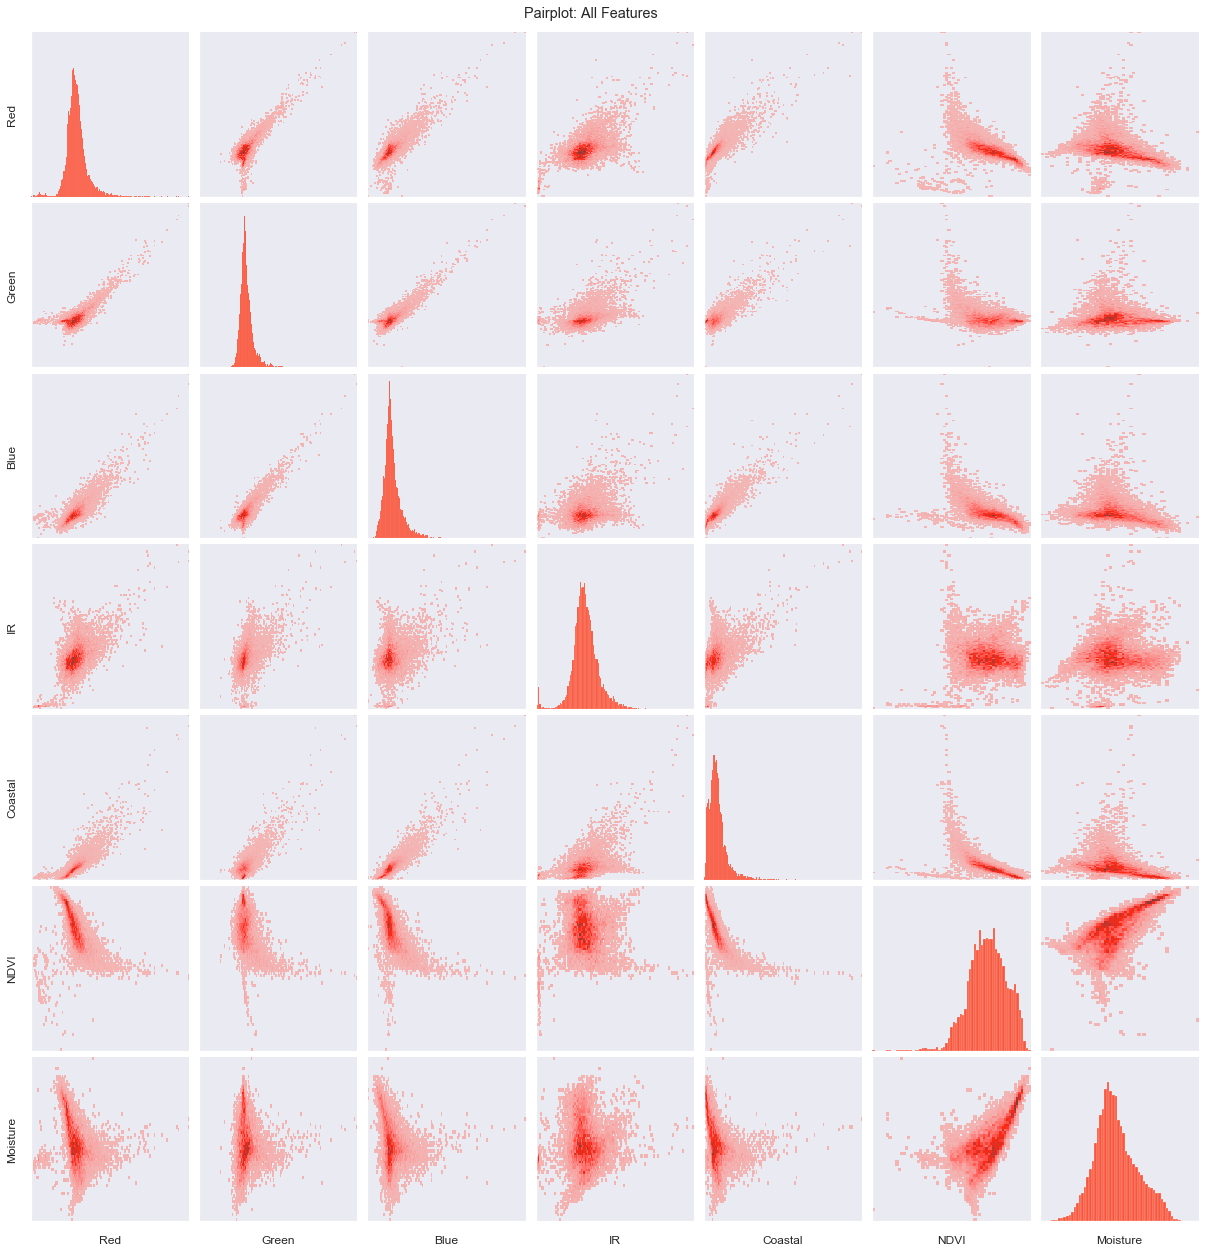

In [17]:
# Full Pairplot
g = sns.pairplot(flat_sample, kind = 'hist')
g.set( xticklabels=[] , yticklabels=[])
g.fig.suptitle('Pairplot: All Features', y=1.0055)
plt.savefig('images/feature_exploration_images/full_pairplot.png', bbox_inches='tight')

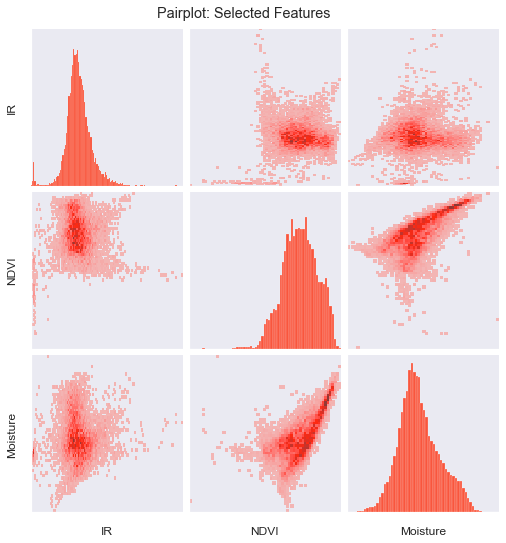

In [13]:
# Pairplot - chosen features
final_sample = flat_sample.drop(columns = ['Red', 'Green', 'Blue', 'Coastal'])

g = sns.pairplot(final_sample, kind = 'hist')
g.set( xticklabels=[] , yticklabels=[])
g.fig.suptitle('Pairplot: Selected Features', y = 1.02)
plt.savefig('images/feature_exploration_images/final_pairplot.png', bbox_inches='tight')